# Final Exam — Machine Learning

## Проект: Formula 2 Championship (Race Results)

**Участники:** Острикова Мария  
**Датасет:** Formula 2 Championship  
**Задачи:**
- Линейная регрессия (с нуля) — предсказание позиции (POS)  
- Логистическая регрессия (с нуля) — классификация: топ-10 vs не топ-10  
- Сравнение со 2-й моделью (Decision Tree из sklearn)  

---


Тема: Formula 2 Championship (updated after every race)

## Источник данных

Источник: https://www.kaggle.com/datasets/alarchemn/formula-2-dataset?resource=download&select=Feature-Race.csv

**О датасете:** Чемпионат FIA Formula 2 — это чемпионат второго уровня по гонкам на одноместных болидах, организованный Международной автомобильной федерацией (FIA). Чемпионат введён в 2017 году после ребрендинга серии GP2.

Помимо того, что это чемпионат, присуждающий много очков для получения суперлицензии FIA, он стал ступенью для многих пилотов Формулы‑1 (Оскар Пиастри, Шарль Леклер, Джордж Рассел, Ландо Норрис, Юки Цунода, Гуанью Чжоу и др.).

### Описание колонок в `Feature-Race.csv`

- `LAPS` - количество кругов  
- `TIME`, `GAP`, `INT.` - время/разрывы (строки)  
- `KPH` - средняя скорость (км/ч)  
- `BEST`, `LAP` - лучший круг / номер круга  
- `POS` - итоговая позиция в гонке  
- `CAR`, `PILOT NAME`, `TEAM` - машина/пилот/команда  
- `CIRCUIT` - трасса  
- `TYPE` - тип заезда  
- `ROUND` - номер этапа  
- `DATE` - дата


!pip -q install ipywidgets

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

df = pd.read_csv("Feature-Race.csv")
df.head()

,LAPS,TIME,GAP,INT.,KPH,BEST,LAP,POS,CAR,PILOT NAME,TEAM,CIRCUIT,TYPE,ROUND,DATE
0,40,53:32.606,-,-,193.406,1:18.735,30.0,1.0,2,N. Matsushita,Carlin,Spielberg,Feature Race,Round 6,2019-06-30
1,40,53:35.569,2.963,2.963,193.228,1:18.602,9.0,2.0,8,L. Ghiotto,UNI-Virtuosi,Spielberg,Feature Race,Round 6,2019-06-30
2,40,53:43.034,10.428,7.465,192.780,1:18.625,12.0,3.0,4,N. de Vries,ART Grand Prix,Spielberg,Feature Race,Round 6,2019-06-30
3,40,53:43.392,10.786,0.358,192.759,1:18.573,10.0,4.0,19,A. Hubert,BWT Arden,Spielberg,Feature Race,Round 6,2019-06-30
4,40,53:45.326,12.720,1.934,192.643,1:18.209,34.0,5.0,5,S. Sette Câmara,DAMS,Spielberg,Feature Race,Round 6,2019-06-30


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAPS        1420 non-null   int64  
 1   TIME        1420 non-null   object 
 2   GAP         1420 non-null   object 
 3   INT.        1420 non-null   object 
 4   KPH         1420 non-null   float64
 5   BEST        1420 non-null   object 
 6   LAP         1420 non-null   float64
 7   POS         1420 non-null   float64
 8   CAR         1420 non-null   int64  
 9   PILOT NAME  1420 non-null   object 
 10  TEAM        1420 non-null   object 
 11  CIRCUIT     1420 non-null   object 
 12  TYPE        1420 non-null   object 
 13  ROUND       1420 non-null   object 
 14  DATE        1420 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 166.5+ KB


### Формулы градиентов

**Линейная регрессия (MSE):**  
Модель: \(\hat{y}=b+\mathbf{x}^\top\mathbf{w}\)  
Функция потерь: \(\displaystyle L=\frac{1}{n}\sum_{i=1}^n (y_i-\hat{y}_i)^2\)

Градиенты:
- \(\displaystyle \frac{\partial L}{\partial \mathbf{w}} = -\frac{2}{n}\mathbf{X}^\top(\mathbf{y}-\hat{\mathbf{y}})\)
- \(\displaystyle \frac{\partial L}{\partial b} = -\frac{2}{n}\sum_{i=1}^n (y_i-\hat{y}_i)\)

**Логистическая регрессия (Log-loss):**  
Модель: \(p=\sigma(b+\mathbf{x}^\top\mathbf{w})\), где \(\sigma(z)=\frac{1}{1+e^{-z}}\)  
Функция потерь: \(\displaystyle L=-\frac{1}{n}\sum_{i=1}^n \left[y_i\log p_i + (1-y_i)\log(1-p_i)\right]\)

Градиенты:
- \(\displaystyle \frac{\partial L}{\partial \mathbf{w}} = \frac{1}{n}\mathbf{X}^\top(\mathbf{p}-\mathbf{y})\)
- \(\displaystyle \frac{\partial L}{\partial b} = \frac{1}{n}\sum_{i=1}^n (p_i-y_i)\)


Линейная регрессия (реализация с нуля).

Я сначала привожу нужные колонки к нормальному виду: чтобы `ROUND`, `LAPS`, `KPH`, `LAP` и `POS` были числами, а всe нечисловое превращалось в пропуски. Потом я беру только нужные столбцы и удаляю строки, где чего-то не хватает. Дальше я превращаю `TEAM` и `CIRCUIT` в набор отдельных колонок 0/1 (да/нет), чтобы модель могла с ними работать. В конце я собираю `X` - это все признаки, и `y` - это позиция `POS`, и смотрю на их размеры.

In [123]:
df["ROUND"] = df["ROUND"].astype(str).str.extract(r"(\d+)").astype(float)

for col in ["LAPS", "KPH", "LAP", "POS"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

num_features = ["LAPS", "KPH", "LAP", "ROUND"]
cat_features = ["TEAM", "CIRCUIT"]

data = df[num_features + cat_features + ["POS"]].dropna()

data = pd.get_dummies(data, columns=cat_features, drop_first=True)

X = data.drop(columns=["POS"]).to_numpy(dtype=float)
y = data["POS"].to_numpy(dtype=float).reshape(-1, 1)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (1420, 47) y shape: (1420, 1)


Тут считаю среднее и стандартное отклонение для каждого признака в `X`, чтобы потом их нормализовать. Если где-то `std=0`, ставлю 1, чтобы не делить на ноль, и делаю стандартизацию: `(X - mean) / std`, чтобы признаки были в одном масштабе.

In [124]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0

X = (X - X_mean) / X_std

Я делаю линейную регрессию с нуля. Сначала добавляю к данным столбец из единиц, чтобы у модели был свободный член (b). Начинаю с нулевых весов и много раз считаю предсказания, смотрю насколько они ошиблись (MSE) и немного меняю веса, чтобы ошибка стала меньше. Если `batch_size` не указан - беру все данные сразу, если указан - обучаюсь по небольшим порциям данных после перемешивания. В конце получаю итоговые веса и как менялась ошибка по эпохам.

In [125]:
def add_bias(X: np.ndarray) -> np.ndarray:
    return np.hstack([np.ones((X.shape[0], 1)), X])

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred) ** 2))

def linear_regression_gd(X: np.ndarray, y: np.ndarray, lr: float = 0.01, epochs: int = 500, batch_size: int | None = None, seed: int = 42):
    Xb = add_bias(X)
    n, d = Xb.shape
    w = np.zeros((d, 1))
    losses = []

    rng = np.random.default_rng(seed)

    for epoch in range(epochs):
        if batch_size is None:
            y_pred = Xb @ w
            grad = (2 / n) * (Xb.T @ (y_pred - y))
            w -= lr * grad
            losses.append(mse(y, y_pred))
        else:
            idx = rng.permutation(n)
            Xs, ys = Xb[idx], y[idx]
            epoch_losses = []
            for start in range(0, n, batch_size):
                xb = Xs[start:start + batch_size]
                yb = ys[start:start + batch_size]
                y_pred = xb @ w
                grad = (2 / len(yb)) * (xb.T @ (y_pred - yb))
                w -= lr * grad
                epoch_losses.append(mse(yb, y_pred))
            losses.append(float(np.mean(epoch_losses)))

    return w, losses

linear_regression_batch_gd = linear_regression_gd

Я обучаю линейную регрессию, запускаю градиентный спуск с `lr=0.01` на 800 эпох и получаю веса модели. Потом разделяю их на свободный член `b` (первое значение) и остальные коэффициенты `w` (для признаков) и вывожу их, чтобы показать, какие параметры модель выучила.

In [126]:
w_lin, losses = linear_regression_gd(X, y, lr=0.01, epochs=800, batch_size=None)

b_lin = float(w_lin[0])
coef_lin = w_lin[1:].flatten()

print("Линейная регрессия (с нуля):")
print("intercept (b):", round(b_lin, 6))
print("coef (w) shape:", coef_lin.shape)
print("Первые 10 коэффициентов:", np.round(coef_lin[:10], 6))

Линейная регрессия (с нуля):
intercept (b): 9.628872
coef (w) shape: (47,)
Первые 10 коэффициентов: [-0.396725 -0.006057  0.012021  0.059449  0.552218  0.808656  1.176434
  0.206726 -0.343695 -0.203519]


/tmp/ipython-input-3539877718.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_lin = float(w_lin[0])


По графику ошибок о эпохам я смотрю, уменьшается ли ошибка со временем и нормально ли обучается линейная регрессия.

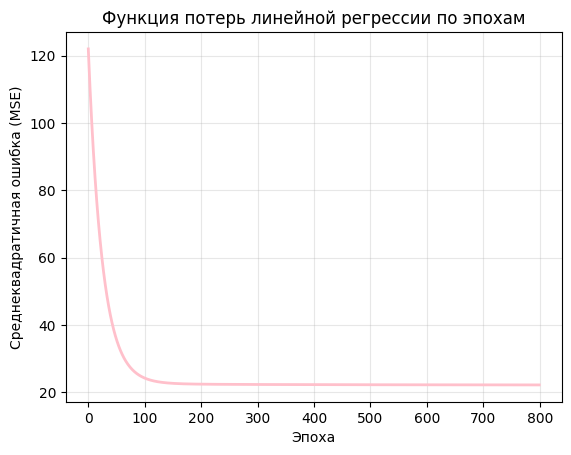

In [127]:
plt.plot(losses, color="pink", linewidth=2)
plt.xlabel("Эпоха")
plt.ylabel("Среднеквадратичная ошибка (MSE)")
plt.title("Функция потерь линейной регрессии по эпохам")
plt.grid(alpha=0.3)
plt.show()

Здесь я проверяю, как скорость обучения влияет на обучение модели. Я беру три значения `lr` (0.001, 0.01, 0.05), для каждого заново обучаю линейную регрессию 400 эпох и сохраняю список ошибок `l`. Потом рисую на одном графике три линии, чтобы сравнить, при каком `lr` ошибка падает быстрее и стабильнее.

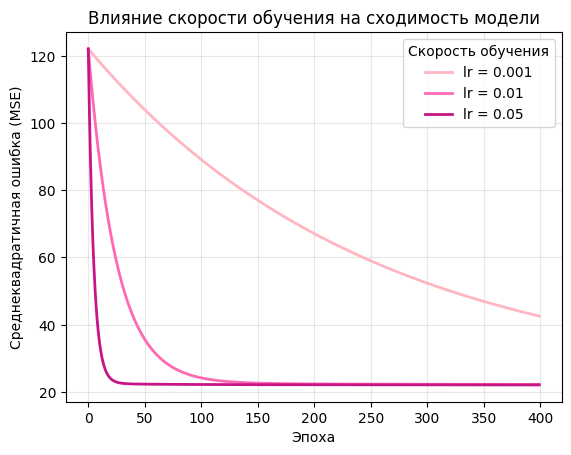

In [128]:
colors = ["#ffb6c1", "#ff69b4", "#c71585"]

lrs = [0.001, 0.01, 0.05]

for lr, color in zip(lrs, colors):
    _, l = linear_regression_batch_gd(X, y, lr=lr, epochs=400)
    plt.plot(l, color=color, linewidth=2, label=f"lr = {lr}")

plt.xlabel("Эпоха")
plt.ylabel("Среднеквадратичная ошибка (MSE)")
plt.title("Влияние скорости обучения на сходимость модели")
plt.legend(title="Скорость обучения")
plt.grid(alpha=0.3)
plt.show()

Я беру из df только `KPH` и `POS`, перевожу их в числа и убираю строки с пропусками. Дальше обучаю простую линейную регрессию, где модель пытается предсказать `POS` только по одному признаку `KPH`, считаю предсказания и вывожу параметры линии: `intercept` (сдвиг) и `slope` (наклон).


In [129]:
vis = df[["KPH", "POS"]].copy()
vis["KPH"] = pd.to_numeric(vis["KPH"], errors="coerce")
vis["POS"] = pd.to_numeric(vis["POS"], errors="coerce")
vis = vis.dropna()

x = vis["KPH"].to_numpy()
y1 = vis["POS"].to_numpy().reshape(-1, 1)

X1 = x.reshape(-1, 1)

w1, _ = linear_regression_gd(X1, y1, lr=1e-7, epochs=3000, batch_size=None)
y_pred = add_bias(X1) @ w1

print("Визуальная модель (POS ~ KPH):")
print("intercept:", float(w1[0]))
print("slope:", float(w1[1]))

Визуальная модель (POS ~ KPH):
intercept: 0.00045951648691760144
slope: 0.05505141007685286


/tmp/ipython-input-4187159832.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("intercept:", float(w1[0]))
/tmp/ipython-input-4187159832.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("slope:", float(w1[1]))


Тут я делаю bootstrap для доверительного интервала. Я 200 раз случайно выбираю строки из данных с повторениями, каждый раз заново обучаю линейную регрессию и сохраняю предсказания. Потом по всем этим предсказаниям беру 5-й и 95-й процентиль - это нижняя и верхняя границы интервала, чтобы показать, в каком диапазоне обычно лежит прогноз модели.

In [130]:
B = 200
preds = np.zeros((B, len(x), 1))

for b in range(B):
    idx = np.random.choice(len(x), len(x), replace=True)
    wb, _ = linear_regression_gd(X1[idx], y1[idx], lr=1e-7, epochs=1500, batch_size=None)
    preds[b] = add_bias(X1) @ wb

lower = np.percentile(preds, 5, axis=0).flatten()
upper = np.percentile(preds, 95, axis=0).flatten()

Тут я сначала сортирую значения x, чтобы линия и заливка рисовались ровно слева направо. Потом строю график, розовые точки - реальные данные (KPH против POS), чёрная линия — предсказание линейной регрессии, а серая область — доверительный интервал (границы из bootstrap: примерно 5–95%).

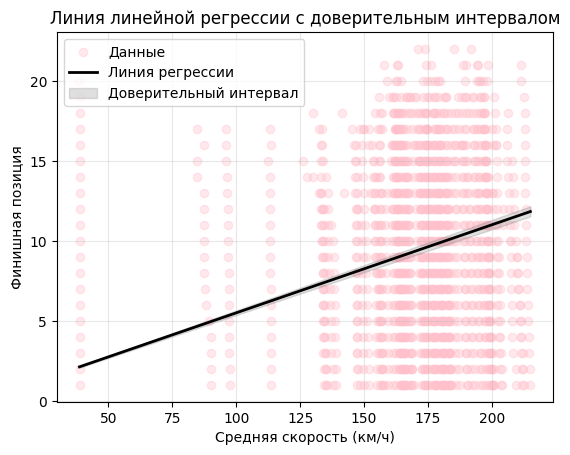

In [131]:
order = np.argsort(x)

plt.scatter(x, y1.flatten(), alpha=0.35, color="pink", label="Данные")
plt.plot(x[order], y_pred.flatten()[order], color="black", lw=2, label="Линия регрессии")
plt.fill_between(x[order], lower[order], upper[order], color="gray", alpha=0.25, label="Доверительный интервал")

plt.xlabel("Средняя скорость (км/ч)")
plt.ylabel("Финишная позиция")
plt.title("Линия линейной регрессии с доверительным интервалом")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Логистическая регрессия (реализация с нуля).

Я превращаю y в бинарную цель для классификации, если позиция ≤ 10, ставлю 1 (топ-10), иначе 0.

In [132]:
y_clf = (y <= 10).astype(int)

Я задаю две функции для логистической регрессии `sigmoid` переводит число в вероятность от 0 до 1, а `log_loss` считает ошибку между настоящими метками и предсказанными вероятностями и обрезает значения, чтобы не было `log(0)`.

In [133]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(
        y_true * np.log(y_pred) +
        (1 - y_true) * np.log(1 - y_pred)
    )

Я обучаю логистическую регрессию градиентным спуском: добавляю bias, считаю вероятности через sigmoid, обновляю веса, сохраняю loss.

In [134]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

def log_loss(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-12) -> float:
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return float(-np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))

def logistic_regression_gd(X: np.ndarray, y: np.ndarray, lr: float = 0.1, epochs: int = 500, batch_size: int | None = None, seed: int = 42):
    Xb = add_bias(X)
    n, d = Xb.shape
    w = np.zeros((d, 1))
    losses = []

    rng = np.random.default_rng(seed)

    for epoch in range(epochs):
        if batch_size is None:
            p = sigmoid(Xb @ w)
            grad = (1 / n) * (Xb.T @ (p - y))
            w -= lr * grad
            losses.append(log_loss(y, p))
        else:
            idx = rng.permutation(n)
            Xs, ys = Xb[idx], y[idx]
            epoch_losses = []
            for start in range(0, n, batch_size):
                xb = Xs[start:start + batch_size]
                yb = ys[start:start + batch_size]
                p = sigmoid(xb @ w)
                grad = (1 / len(yb)) * (xb.T @ (p - yb))
                w -= lr * grad
                epoch_losses.append(log_loss(yb, p))
            losses.append(float(np.mean(epoch_losses)))

    return w, losses

logistic_regression_batch_gd = logistic_regression_gd

Обучаю логистическую регрессию на данных `X` и метках `y_clf`, потом разделяю полученные веса на `b` (свободный член) и `w` (коэффициенты при признаках) и вывожу их, чтобы показать, чему научилась модель.


In [135]:
w_log, losses_log = logistic_regression_gd(
    X, y_clf.reshape(-1, 1),
    lr=0.05,
    epochs=600,
    batch_size=None
)

b_log = float(w_log[0])
coef_log = w_log[1:].flatten()

print("Логистическая регрессия (с нуля):")
print("intercept (b):", round(b_log, 6))
print("coef (w) shape:", coef_log.shape)
print("Первые 10 коэффициентов:", np.round(coef_log[:10], 6))

Логистическая регрессия (с нуля):
intercept (b): 0.245669
coef (w) shape: (47,)
Первые 10 коэффициентов: [ 0.060237  0.035023  0.032827 -0.017767 -0.157466 -0.281449 -0.317331
 -0.047423  0.211209  0.136524]


/tmp/ipython-input-2549534278.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_log = float(w_log[0])


Я строю график losses_log по оси X - эпохи обучения, по оси Y - значение log-loss. По нему я проверяю, уменьшается ли ошибка со временем и нормально ли обучается логистическая регрессия.

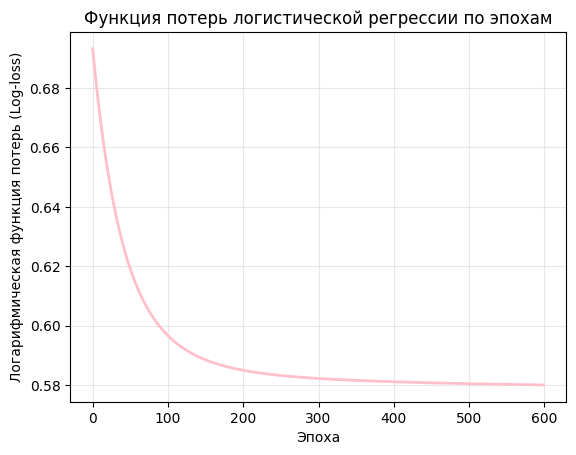

In [136]:
plt.plot(losses_log, color="pink", lw=2)
plt.xlabel("Эпоха")
plt.ylabel("Логарифмическая функция потерь (Log-loss)")
plt.title("Функция потерь логистической регрессии по эпохам")
plt.grid(alpha=0.3)
plt.show()

Тут я получаю предсказания логистической регрессии и считаю качество. Сначала считаю вероятности класса 1 (`y_prob`) через sigmoid, потом превращаю их в метки 0/1 по порогу 0.5 (`y_pred`). Дальше считаю основные метрики (accuracy, precision, recall, F1) и ROC AUC и вывожу их, чтобы оценить, насколько хорошо модель классифицирует.

In [137]:
y_prob = sigmoid(add_bias(X) @ w_log)
y_pred = (y_prob >= 0.5).astype(int).flatten()

accuracy = accuracy_score(y_clf, y_pred)
precision = precision_score(y_clf, y_pred, zero_division=0)
recall = recall_score(y_clf, y_pred, zero_division=0)
f1 = f1_score(y_clf, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_clf, y_prob)

print("Логистическая регрессия (с нуля):")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {roc_auc:.3f}")

Логистическая регрессия (с нуля):
Accuracy : 0.706
Precision: 0.707
Recall   : 0.805
F1-score : 0.753
ROC AUC  : 0.752


Тут я строю матрицу ошибок для логистической регрессии. Сначала считаю confusion_matrix, потом рисую её как картинку, по оси X - предсказанный класс, по оси Y - настоящий класс, а числа в клетках показывают, сколько объектов попало в каждую ситуацию.

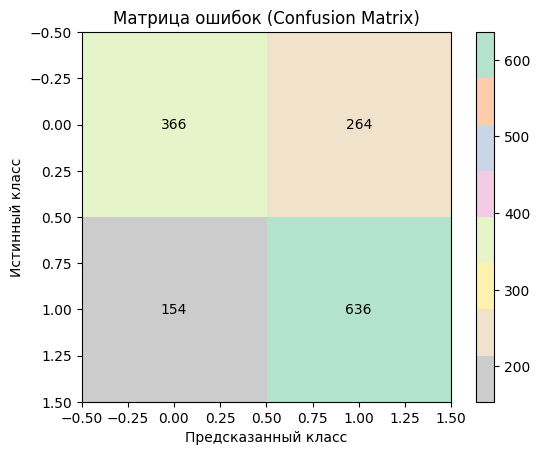

In [138]:
cm = confusion_matrix(y_clf, y_pred)

plt.imshow(cm, cmap="Pastel2_r")
plt.title("Матрица ошибок (Confusion Matrix)")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()

Тут строю ROC-кривую: по вероятностям `y_prob` считаю TPR и FPR для разных порогов, считаю ROC AUC и рисую график, чтобы увидеть, насколько хорошо модель различает классы.


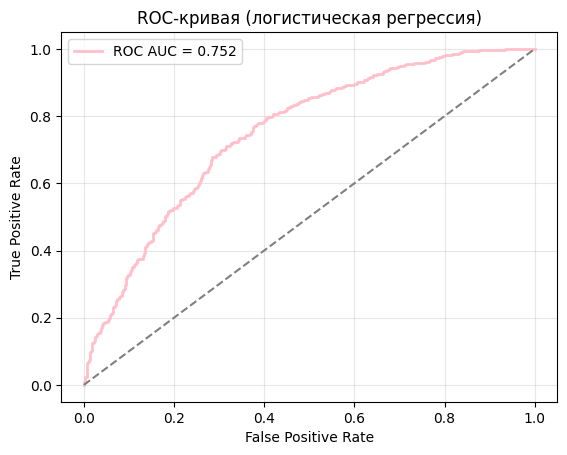

In [139]:
fpr, tpr, _ = roc_curve(y_clf, y_prob.ravel())
roc_auc_val = auc(fpr, tpr)

plt.plot(fpr, tpr, color="pink", lw=2, label=f"ROC AUC = {roc_auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая (логистическая регрессия)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Классификация (два подхода)

В работе решается задача **бинарной классификации**: предсказать, попадёт ли пилот в **топ‑10** по итогам гонки.

- Класс **1**: `POS <= 10` (топ‑10)  
- Класс **0**: `POS > 10` (не топ‑10)

Два подхода:
1) **Логистическая регрессия** - обучаем с градиентным спуском и считаем метрики.  
2) **Decision Tree (sklearn)** - как альтернативная модель для сравнения.


Я беру позиции `POS` и превращаю их в 3 класса: 2 - подиум (1–3), 1 - очковые места (4–10), 0 - остальные.

In [149]:
pos = data["POS"].values
y_mc = np.where(pos <= 3, 2, np.where(pos <= 10, 1, 0))

Я сравниваю предсказанные классы `y_pred` с настоящими `y_clf`, считаю основные метрики качества (accuracy, precision, recall, F1 и ROC AUC) и вывожу их, чтобы понять, насколько хорошо работает логистическая регрессия.

In [150]:
accuracy = accuracy_score(y_clf, y_pred)
precision = precision_score(y_clf, y_pred)
recall = recall_score(y_clf, y_pred)
f1 = f1_score(y_clf, y_pred)
roc_auc = roc_auc_score(y_clf, y_prob)

print("Логистическая регрессия:")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {roc_auc:.3f}")

Логистическая регрессия:
Accuracy : 0.706
Precision: 0.707
Recall   : 0.805
F1-score : 0.753
ROC AUC  : 0.752


Я обучаю дерево решений на данных `X` и метках `y_clf`, потом получаю его предсказанные классы `y_pred_tree` и вероятности класса 1 `y_prob_tree`, чтобы дальше посчитать метрики и построить графики.

In [142]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y_clf)

y_pred_tree = tree.predict(X)
y_prob_tree = tree.predict_proba(X)[:, 1]

Оцениваю дерево решений, считаю предсказания и по ним вычисляю метрики, чтобы понять качество модели. Потом строю матрицу ошибок, чтобы увидеть где модель путается, и ROC-кривую, чтобы посмотреть, как хорошо дерево разделяет классы при разных порогах.

Decision Tree (sklearn):
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000
ROC AUC  : 1.000


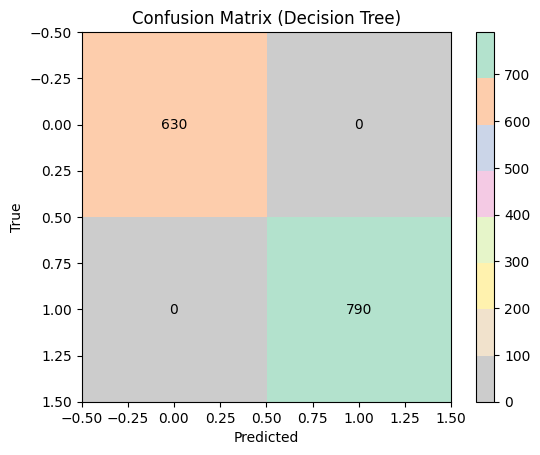

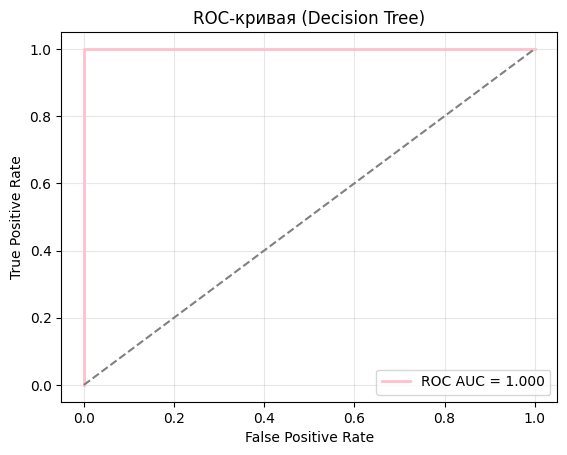

In [152]:
accuracy_t = accuracy_score(y_clf, y_pred_tree)
precision_t = precision_score(y_clf, y_pred_tree, zero_division=0)
recall_t = recall_score(y_clf, y_pred_tree, zero_division=0)
f1_t = f1_score(y_clf, y_pred_tree, zero_division=0)
roc_auc_t = roc_auc_score(y_clf, y_prob_tree)

print("Decision Tree (sklearn):")
print(f"Accuracy : {accuracy_t:.3f}")
print(f"Precision: {precision_t:.3f}")
print(f"Recall   : {recall_t:.3f}")
print(f"F1-score : {f1_t:.3f}")
print(f"ROC AUC  : {roc_auc_t:.3f}")

cm_t = confusion_matrix(y_clf, y_pred_tree)
plt.imshow(cm_t, cmap="Pastel2_r")
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_t[i, j], ha="center", va="center", color="black")
plt.show()

fpr_t, tpr_t, _ = roc_curve(y_clf, y_prob_tree)
roc_auc_val_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, color="pink", lw=2, label=f"ROC AUC = {roc_auc_val_t:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая (Decision Tree)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Эксперименты и метрики.


Тут делаю два эксперимента для логистической регрессии, сначала обучаю модель с разными `learning rate` и рисую линиями, как меняется `log-loss` по эпохам. Потом обучаю модель с разными `batch_size` (весь датасет, 32 и 128), считаю итоговый `log-loss`, accuracy и ROC AUC и собираю результаты в таблицу для сравнения.

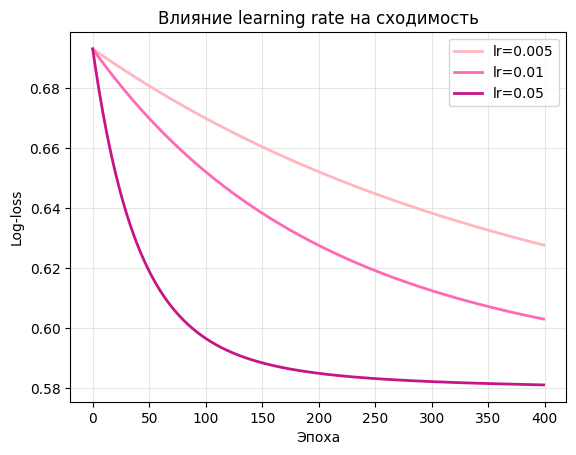

,batch_size,final_logloss,accuracy,roc_auc
0,Batch,0.581103,0.704225,0.751644
1,32,0.581878,0.703521,0.754105
2,128,0.568928,0.700000,0.753106


In [153]:
plt.figure()
pink_colors = ["#ffb6c1", "#ff69b4", "#c71585"]
for lr, c in zip([0.005, 0.01, 0.05], pink_colors):
    w_tmp, loss_tmp = logistic_regression_gd(X, y_clf.reshape(-1, 1), lr=lr, epochs=400, batch_size=None)
    plt.plot(loss_tmp, lw=2, color=c, label=f"lr={lr}")

plt.xlabel("Эпоха")
plt.ylabel("Log-loss")
plt.title("Влияние learning rate на сходимость")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

rows = []
for bs in [None, 32, 128]:
    w_tmp, loss_tmp = logistic_regression_gd(X, y_clf.reshape(-1, 1), lr=0.05, epochs=400, batch_size=bs)
    prob_tmp = sigmoid(add_bias(X) @ w_tmp).ravel()
    pred_tmp = (prob_tmp >= 0.5).astype(int)
    rows.append({
        "batch_size": "Batch" if bs is None else bs,
        "final_logloss": loss_tmp[-1],
        "accuracy": accuracy_score(y_clf, pred_tmp),
        "roc_auc": roc_auc_score(y_clf, prob_tmp)
    })

pd.DataFrame(rows)

Собираю в одну таблицу результаты двух моделей (логистическая регрессия и Decision Tree из sklearn) и считаю для каждой Accuracy, Precision, Recall, F1 и ROC AUC и вывожу таблицу, чтобы удобно сравнить качество моделей.

In [154]:
results = pd.DataFrame({
    "Модель": ["Логистическая (с нуля)", "Decision Tree (sklearn)"],
    "Accuracy": [
        accuracy_score(y_clf, y_pred),
        accuracy_score(y_clf, y_pred_tree)
    ],
    "Precision": [
        precision_score(y_clf, y_pred, zero_division=0),
        precision_score(y_clf, y_pred_tree, zero_division=0)
    ],
    "Recall": [
        recall_score(y_clf, y_pred, zero_division=0),
        recall_score(y_clf, y_pred_tree, zero_division=0)
    ],
    "F1-score": [
        f1_score(y_clf, y_pred, zero_division=0),
        f1_score(y_clf, y_pred_tree, zero_division=0)
    ],
    "ROC AUC": [
        roc_auc_score(y_clf, y_prob.ravel()),
        roc_auc_score(y_clf, y_prob_tree)
    ]
})

results

,Модель,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Логистическая (с нуля),0.705634,0.706667,0.805063,0.752663,0.752427
1,Decision Tree (sklearn),1.000000,1.000000,1.000000,1.000000,1.000000


Логистическая регрессия является линейной моделью и обычно даёт более стабильные результаты на стандартизированных признаках, а также меньше склонна к переобучению. Решающее дерево способно улавливать нелинейные зависимости, но при увеличении глубины может переобучаться. Ограничение max_depth снижает переобучение, но может уменьшить качество, если зависимость сложная.

Я делаю интерактивную часть проекта создаю виджеты, чтобы можно было загрузить свой CSV, выбрать модель (линейная/логистическая или дерево), настроить параметры обучения (lr, epochs, batch, max_depth) и запустить. После нажатия я автоматически подготавливаю данные (чистка, one-hot, нормализация), обучаю выбранную модель и вывожу результаты: метрики и графики (loss и confusion matrix), а для дерева показываю параметры только когда оно выбрано.

In [155]:
import io
from sklearn.tree import DecisionTreeClassifier

uploader = widgets.FileUpload(accept=".csv", multiple=False, description="Загрузить CSV")

model_dd = widgets.Dropdown(
    options=[
        "Линейная регрессия (с нуля)",
        "Логистическая регрессия (с нуля)",
        "Decision Tree (sklearn)"
    ],
    description="Модель:"
)

lr_sl = widgets.FloatLogSlider(value=0.01, base=10, min=-5, max=0, step=0.1, description="lr:")
epochs_sl = widgets.IntSlider(value=400, min=50, max=2000, step=50, description="epochs:")
batch_dd = widgets.Dropdown(options=[("Batch", None), ("32", 32), ("128", 128)], description="batch:")

max_depth_sl = widgets.IntSlider(value=5, min=1, max=20, step=1, description="max_depth:")

btn = widgets.Button(description="Запустить", button_style="success")
out = widgets.Output()

def prepare_xy(df_in: pd.DataFrame):
    if "ROUND" in df_in.columns:
        df_in = df_in.copy()
        df_in["ROUND"] = df_in["ROUND"].astype(str).str.extract(r"(\d+)").astype(float)

    for col in ["LAPS", "KPH", "LAP", "POS", "ROUND"]:
        if col in df_in.columns:
            df_in[col] = pd.to_numeric(df_in[col], errors="coerce")

    num_features = [c for c in ["LAPS", "KPH", "LAP", "ROUND"] if c in df_in.columns]
    cat_features = [c for c in ["TEAM", "CIRCUIT"] if c in df_in.columns]

    if "POS" not in df_in.columns:
        raise ValueError("В датасете нет колонки POS — обновите prepare_xy под ваш CSV.")

    data = df_in[num_features + cat_features + ["POS"]].dropna()

    if len(cat_features) > 0:
        data = pd.get_dummies(data, columns=cat_features, drop_first=True)

    X = data.drop(columns=["POS"]).to_numpy(dtype=float)
    y_reg = data["POS"].to_numpy(dtype=float).reshape(-1, 1)
    y_bin = (y_reg.flatten() <= 10).astype(int)

    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std[X_std == 0] = 1.0
    X = (X - X_mean) / X_std

    return X, y_reg, y_bin

def load_df_from_upload_or_existing():
    if uploader.value:
        item = next(iter(uploader.value.values()))
        content = item["content"]
        return pd.read_csv(io.BytesIO(content))
    return df

def run(_):
    with out:
        clear_output()

        df_local = load_df_from_upload_or_existing()
        print("Размер данных:", df_local.shape)

        X_local, y_reg, y_bin = prepare_xy(df_local)

        lr = float(lr_sl.value)
        epochs = int(epochs_sl.value)
        bs = batch_dd.value

        if model_dd.value == "Линейная регрессия (с нуля)":
            w, loss = linear_regression_gd(X_local, y_reg, lr=lr, epochs=epochs, batch_size=bs)
            y_hat = add_bias(X_local) @ w

            print("\nЛинейная регрессия (с нуля)")
            print("MSE:", round(mse(y_reg, y_hat), 6))
            print("intercept:", float(w[0]))
            print("первые 10 coef:", np.round(w[1:11].flatten(), 6))

            plt.plot(loss, lw=2)
            plt.xlabel("Эпоха"); plt.ylabel("MSE")
            plt.title("Loss (MSE) по эпохам")
            plt.grid(alpha=0.3); plt.show()

        elif model_dd.value == "Логистическая регрессия (с нуля)":
            w, loss = logistic_regression_gd(X_local, y_bin.reshape(-1, 1), lr=lr, epochs=epochs, batch_size=bs)

            prob = sigmoid(add_bias(X_local) @ w).ravel()
            pred = (prob >= 0.5).astype(int)

            print("\nЛогистическая регрессия (с нуля)")
            print("intercept:", float(w[0]))
            print("первые 10 coef:", np.round(w[1:11].flatten(), 6))
            print("Accuracy :", round(accuracy_score(y_bin, pred), 4))
            print("Precision:", round(precision_score(y_bin, pred, zero_division=0), 4))
            print("Recall   :", round(recall_score(y_bin, pred, zero_division=0), 4))
            print("F1-score :", round(f1_score(y_bin, pred, zero_division=0), 4))
            print("ROC AUC  :", round(roc_auc_score(y_bin, prob), 4))

            plt.plot(loss, lw=2)
            plt.xlabel("Эпоха"); plt.ylabel("Log-loss")
            plt.title("Loss (Log-loss) по эпохам")
            plt.grid(alpha=0.3); plt.show()

            cm = confusion_matrix(y_bin, pred)
            plt.imshow(cm, cmap="pink")
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted"); plt.ylabel("True")
            plt.colorbar()
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
            plt.show()

        else:
            tree = DecisionTreeClassifier(max_depth=int(max_depth_sl.value), random_state=42)
            tree.fit(X_local, y_bin)
            pred = tree.predict(X_local)
            prob = tree.predict_proba(X_local)[:, 1]

            print("\nDecision Tree (sklearn)")
            print("Accuracy :", round(accuracy_score(y_bin, pred), 4))
            print("Precision:", round(precision_score(y_bin, pred, zero_division=0), 4))
            print("Recall   :", round(recall_score(y_bin, pred, zero_division=0), 4))
            print("F1-score :", round(f1_score(y_bin, pred, zero_division=0), 4))
            print("ROC AUC  :", round(roc_auc_score(y_bin, prob), 4))

            cm = confusion_matrix(y_bin, pred)
            plt.imshow(cm, cmap="pink")
            plt.title("Confusion Matrix (Decision Tree)")
            plt.xlabel("Predicted"); plt.ylabel("True")
            plt.colorbar()
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
            plt.show()

btn.on_click(run)

def toggle_tree_params(*args):
    max_depth_sl.layout.display = "block" if model_dd.value == "Decision Tree (sklearn)" else "none"

model_dd.observe(toggle_tree_params, names="value")
toggle_tree_params()

display(widgets.VBox([uploader, model_dd, lr_sl, epochs_sl, batch_dd, max_depth_sl, btn, out]))
